# Introduction
How to open and understand the dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
#Adding this for change
print("Imports complete")

Imports complete


## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [181]:
hsi_path = '/Users/nathanzlomke/Downloads/train_data/train_data/1570.npz'
gt_path = '/Users/nathanzlomke/Downloads/train_data/train_gt.csv'
wavelength_path = '/Users/nathanzlomke/Downloads/train_data/wavelengths.csv'

In [182]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [183]:
gt_df[gt_df['sample_index']==1570]

,sample_index,P,K,Mg,pH
1570,1570,47.9,165.0,181.0,6.8


## Displaying one hyperspectral band

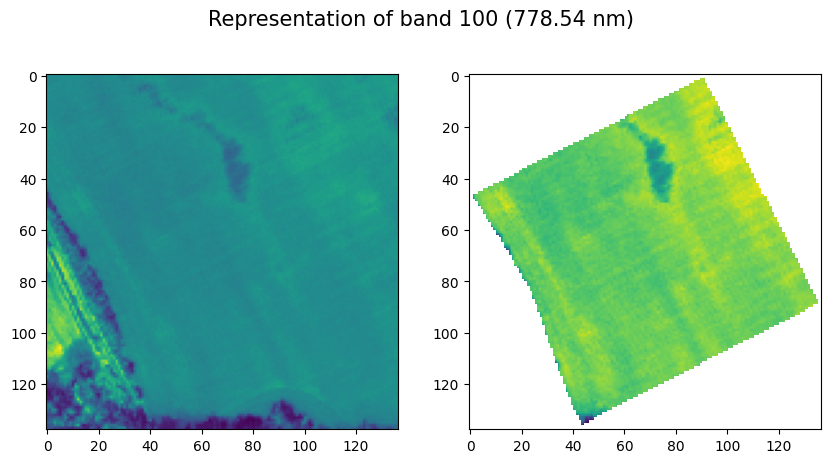

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

## Displaying the aggregated spectral curve for a field

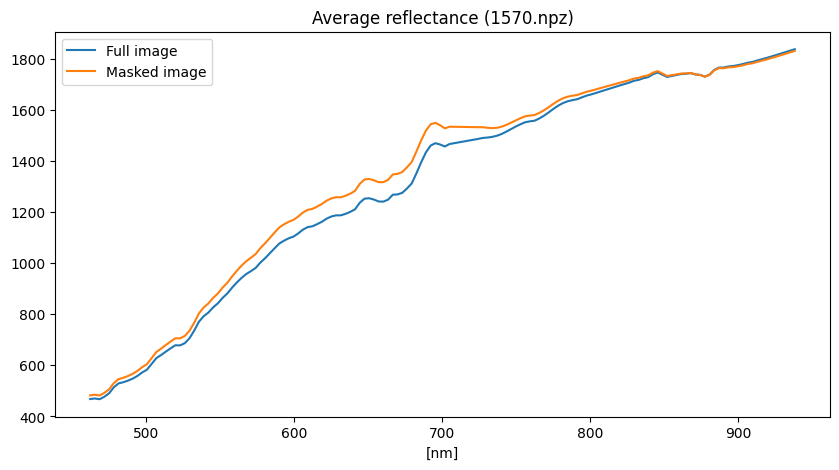

In [185]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()
#Change

# Generating baseline solution

In [1]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))
    print("Complete")


NameError: name 'np' is not defined

H## Load the data

In [187]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels

X_train = load_data("/Users/nathanzlomke/Downloads/train_data/train_data") #X_train = load_data("train_data")
y_train = load_gt(gt_path) #y_train = load_gt("train_gt.csv")
X_test = load_data("/Users/nathanzlomke/Downloads/test_data") #X_test = load_data("test_data")

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Train data shape: (1732, 150)
Test data shape: (1154, 150)


In [188]:
X_train.shape

(1732, 150)

In [189]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV

# Create separate scalers for X_train and Y_train
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)

# Building a CNN Model

In [190]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for hyperparameter optimization
param_grid = {
    'num_filters': [128, 172, 256],
    'kernel_size': [1,2, 3, 5],
    'num_units': [32, 64],
    'learning_rate': [0.03, 0.05],
    'batch_size': [16, 32],
    'epochs': [30,40]
}

# Create an instance of your custom Keras regressor
keras_regressor = CustomKerasRegressor()

# Create a RandomizedSearchCV instance
random_search = RandomizedSearchCV(
    keras_regressor,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    cv=3,  # Cross-validation folds
    scoring='neg_mean_squared_error',  # Specify the scoring metric
    verbose=2,  # Increase verbosity to see progress
    n_jobs=-1,  # Use all available CPU cores
)

# Ensure your data is in NumPy arrays if it's not already
X_train = np.array(X_train_scaled)
y_train = np.array(Y_train_scaled)

# Perform the hyperparameter search
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)  # Negate the score to get the actual MSE

    ##Best Parameters: {'num_units': 64, 'num_filters': 64, 'learning_rate': 0.01, 'kernel_size': 5, 'epochs': 20, 'batch_size': 32}
    #Best Parameters: {'num_units': 128, 'num_filters': 128, 'learning_rate': 0.03, 'kernel_size': 3, 'epochs': 30, 'batch_size': 32}
    #Best Parameters: {'num_units': 64, 'num_filters': 172, 'learning_rate': 0.03, 'kernel_size': 1, 'epochs': 40, 'batch_size': 32}


In [155]:
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'num_units': 64, 'num_filters': 172, 'learning_rate': 0.03, 'kernel_size': 1, 'epochs': 40, 'batch_size': 32}


In [198]:
from sklearn.base import BaseEstimator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np

class CustomKerasRegressor(BaseEstimator):
    def __init__(self, input_shape=(150, 1), num_filters=172, kernel_size=1, pool_size=2, num_units=64, learning_rate=0.03,
                 batch_size=32, epochs=40):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.num_units = num_units
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        # Initialize the model and compile it
        self.model = self.build_model()
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')

        # Fit the model with your data
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs)

        return self

    def build_model(self):
        model = Sequential()
        model.add(Conv1D(self.num_filters, self.kernel_size, activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling1D(self.pool_size))
        model.add(Conv1D(self.num_filters, self.kernel_size, activation='relu'))
        model.add(MaxPooling1D(self.pool_size))

        model.add(Flatten())
        model.add(Dense(self.num_units, activation='relu'))
        model.add(BatchNormalization())  # Adding Batch Normalization layer
        model.add(Dense(4, kernel_regularizer=l2(0.01)))  # Output layer with 4 units for regression (4 target variables)

        return model

# Create an instance of your custom Keras regressor
keras_regressor = CustomKerasRegressor()

# Ensure your data is in NumPy arrays if it's not already
X_train = np.array(X_train_scaled)
y_train = np.array(Y_train_scaled)

# Fit and evaluate your model
keras_regressor.fit(X_train, y_train)


Epoch 1/40
55/55 [==============================] - 2s 16ms/step - loss: 1.2163
Epoch 2/40
55/55 [==============================] - 1s 16ms/step - loss: 1.0102
Epoch 3/40
55/55 [==============================] - 1s 15ms/step - loss: 1.0058
Epoch 4/40
55/55 [==============================] - 1s 16ms/step - loss: 1.0023
Epoch 5/40
55/55 [==============================] - 1s 15ms/step - loss: 1.0008
Epoch 6/40
55/55 [==============================] - 1s 15ms/step - loss: 0.9877
Epoch 7/40
55/55 [==============================] - 1s 15ms/step - loss: 1.0115
Epoch 8/40
55/55 [==============================] - 1s 17ms/step - loss: 0.9978
Epoch 9/40
55/55 [==============================] - 1s 17ms/step - loss: 0.9906
Epoch 10/40
55/55 [==============================] - 1s 17ms/step - loss: 0.9825
Epoch 11/40
55/55 [==============================] - 1s 18ms/step - loss: 0.9785
Epoch 12/40
55/55 [==============================] - 1s 20ms/step - loss: 0.9801
Epoch 13/40
55/55 [==================

CustomKerasRegressor()

In [225]:

# Make predictions with the model
Y_pred_scaled = keras_regressor.model.predict(X_test_scaled)

# Unscale the predicted Y values
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)

#y_pred contains the predicted values for the test data
print(Y_pred_scaled)


37/37 [==============================] - 0s 5ms/step
[[ -9.717759     4.0123854   -6.472507    13.784896  ]
 [ -9.200756     9.031293    -4.9653616   13.773935  ]
 [-14.8336315    5.169455    -9.804387    21.774261  ]
 ...
 [  0.42737252  16.718252    -1.9761701    7.57301   ]
 [ -1.6427006    6.8152604   -2.4044712    3.9515564 ]
 [ -3.5617306    0.44649568  -2.8953245    3.1012933 ]]


## Old model, basic, not optimized

In [ ]:
'''from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(150, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4))  # 4 output units for your 4 soil parameters

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # You can use RMSE as a loss function here.

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))


In [203]:
#Match index with Sample ID Numbers in filename
directory = '/Users/nathanzlomke/Downloads/test_data'
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
sample_nums = []
for file_name in files:
    file_name = file_name.replace('.npz','')
    sample_nums.append(file_name)
print(sample_nums)

['77', '837', '189', '63', '823', '638', '610', '88', '176', '162', '604', '1145', '1151', '348', '374', '412', '406', '360', '599', '1019', '1031', '1025', '228', '200', '566', '572', '214', '943', '957', '758', '980', '994', '764', '770', '771', '765', '995', '981', '759', '956', '942', '573', '215', '201', '567', '229', '1024', '1030', '1018', '598', '407', '361', '375', '413', '349', '1150', '1144', '163', '605', '89', '611', '177', '639', '822', '62', '836', '76', '188', '60', '820', '74', '834', '48', '808', '149', '607', '161', '175', '613', '388', '1152', '1146', '439', '363', '405', '411', '377', '1026', '1032', '559', '217', '571', '565', '203', '954', '940', '798', '968', '997', '983', '773', '767', '766', '772', '982', '996', '969', '799', '941', '955', '564', '202', '216', '570', '558', '1033', '1027', '410', '376', '362', '404', '438', '1147', '1153', '389', '174', '612', '606', '160', '148', '809', '49', '835', '75', '821', '61', '59', '819', '65', '825', '71', '831', '1

In [204]:
#Add header names
predictionsDF = pd.DataFrame(data = Y_pred, columns= ['P','K','Mg','pH'])
#Change index to sample number
predictionsDF.index = sample_nums
predictionsDF.head()


,P,K,Mg,pH
77,69.760979,218.936523,161.177505,6.783410
837,69.471268,221.144211,163.364319,6.753882
189,69.021950,224.734802,162.846756,6.732178
63,69.809090,216.253784,163.358444,6.782103
823,70.902870,214.568146,160.729279,6.822663


In [205]:
#scale predictions by baseline regressor values for submission
baseline_values = pd.read_csv('/Users/nathanzlomke/Downloads/baseline_regressor_values.csv')
baseline_values = baseline_values.drop(columns='sample_index')
baseline_values.head()


,P,K,Mg,pH
0,70.302656,227.98851,159.281236,6.782719
1,70.302656,227.98851,159.281236,6.782719
2,70.302656,227.98851,159.281236,6.782719
3,70.302656,227.98851,159.281236,6.782719
4,70.302656,227.98851,159.281236,6.782719


In [206]:
scaled_predictions = Y_pred / baseline_values
scaled_predictions.head()


,P,K,Mg,pH
0,0.992295,0.960296,1.011905,1.000102
1,0.988174,0.969980,1.025634,0.995748
2,0.981783,0.985729,1.022385,0.992549
3,0.992979,0.948529,1.025598,0.999909
4,1.008538,0.941136,1.009091,1.005889


In [207]:
#Make into singular column format and output submission file
#P_df = pd.DataFrame(P_df)
P_df = scaled_predictions.iloc[:,0]
P_index = predictionsDF.index.astype(str)+'_P'


#K_df = pd.DataFrame(K_df)
K_df = scaled_predictions.iloc[:,1]
K_index = predictionsDF.index.astype(str)+'_K'

#Mg_df = pd.DataFrame(Mg_df)
Mg_df = scaled_predictions.iloc[:,2]
Mg_index = predictionsDF.index.astype(str)+'_Mg'

#pH_df = pd.DataFrame(pH_df)
pH_df = scaled_predictions.iloc[:,3]
pH_index = predictionsDF.index.astype(str)+'_pH'

sample_index=[]
for i in range(len(P_index)):
    sample_index.append(P_index[i])
    sample_index.append(K_index[i])
    sample_index.append(Mg_index[i])
    sample_index.append(pH_index[i])
sample_index

['77_P',
 '77_K',
 '77_Mg',
 '77_pH',
 '837_P',
 '837_K',
 '837_Mg',
 '837_pH',
 '189_P',
 '189_K',
 '189_Mg',
 '189_pH',
 '63_P',
 '63_K',
 '63_Mg',
 '63_pH',
 '823_P',
 '823_K',
 '823_Mg',
 '823_pH',
 '638_P',
 '638_K',
 '638_Mg',
 '638_pH',
 '610_P',
 '610_K',
 '610_Mg',
 '610_pH',
 '88_P',
 '88_K',
 '88_Mg',
 '88_pH',
 '176_P',
 '176_K',
 '176_Mg',
 '176_pH',
 '162_P',
 '162_K',
 '162_Mg',
 '162_pH',
 '604_P',
 '604_K',
 '604_Mg',
 '604_pH',
 '1145_P',
 '1145_K',
 '1145_Mg',
 '1145_pH',
 '1151_P',
 '1151_K',
 '1151_Mg',
 '1151_pH',
 '348_P',
 '348_K',
 '348_Mg',
 '348_pH',
 '374_P',
 '374_K',
 '374_Mg',
 '374_pH',
 '412_P',
 '412_K',
 '412_Mg',
 '412_pH',
 '406_P',
 '406_K',
 '406_Mg',
 '406_pH',
 '360_P',
 '360_K',
 '360_Mg',
 '360_pH',
 '599_P',
 '599_K',
 '599_Mg',
 '599_pH',
 '1019_P',
 '1019_K',
 '1019_Mg',
 '1019_pH',
 '1031_P',
 '1031_K',
 '1031_Mg',
 '1031_pH',
 '1025_P',
 '1025_K',
 '1025_Mg',
 '1025_pH',
 '228_P',
 '228_K',
 '228_Mg',
 '228_pH',
 '200_P',
 '200_K',
 '200_

In [208]:
outputCSV = []
#If running newer Python 3.11, this append converts the dF into a list format and needs to be converted back to dF with indexing
for i in range(len(pH_df)):
    outputCSV.append(P_df[i])
    outputCSV.append(K_df[i])
    outputCSV.append(Mg_df[i])
    outputCSV.append(pH_df[i])
outputCSV = pd.DataFrame(outputCSV)

In [209]:
outputCSV.index = sample_index
outputCSV = outputCSV.rename(columns={0: 'Target'})

outputCSV.head()

,Target
77_P,0.992295
77_K,0.960296
77_Mg,1.011905
77_pH,1.000102
837_P,0.988174


In [210]:
outputCSV.to_csv("/Users/nathanzlomke/Downloads/CNN_optimized_output10.csv", index_label='sample_index')

## Output Indexing Prep

In [123]:
#Match index with Sample ID Numbers in filename
directory = '/Users/nathanzlomke/Downloads/test_data'
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
sample_nums = []
for file_name in files:
    file_name = file_name.replace('.npz','')
    sample_nums.append(file_name)
print(sample_nums)

['77', '837', '189', '63', '823', '638', '610', '88', '176', '162', '604', '1145', '1151', '348', '374', '412', '406', '360', '599', '1019', '1031', '1025', '228', '200', '566', '572', '214', '943', '957', '758', '980', '994', '764', '770', '771', '765', '995', '981', '759', '956', '942', '573', '215', '201', '567', '229', '1024', '1030', '1018', '598', '407', '361', '375', '413', '349', '1150', '1144', '163', '605', '89', '611', '177', '639', '822', '62', '836', '76', '188', '60', '820', '74', '834', '48', '808', '149', '607', '161', '175', '613', '388', '1152', '1146', '439', '363', '405', '411', '377', '1026', '1032', '559', '217', '571', '565', '203', '954', '940', '798', '968', '997', '983', '773', '767', '766', '772', '982', '996', '969', '799', '941', '955', '564', '202', '216', '570', '558', '1033', '1027', '410', '376', '362', '404', '438', '1147', '1153', '389', '174', '612', '606', '160', '148', '809', '49', '835', '75', '821', '61', '59', '819', '65', '825', '71', '831', '1

In [124]:
#Add header names
predictionsDF = pd.DataFrame(data = predictions, columns= ['P','K','Mg','pH'])
#Change index to sample number
predictionsDF.index = sample_nums
predictionsDF.head()


,P,K,Mg,pH
77,-38.845940,175.392380,184.172974,71.859871
837,-29.952654,191.331680,195.483002,36.625034
189,-73.736176,192.993088,226.587387,91.633682
63,-80.022408,199.317413,258.022461,97.636978
823,54.666374,170.369308,85.061409,-66.881508


In [125]:
#scale predictions by baseline regressor values for submission
baseline_values = pd.read_csv('/Users/nathanzlomke/Downloads/baseline_regressor_values.csv')
baseline_values = baseline_values.drop(columns='sample_index')
baseline_values.head()


,P,K,Mg,pH
0,70.302656,227.98851,159.281236,6.782719
1,70.302656,227.98851,159.281236,6.782719
2,70.302656,227.98851,159.281236,6.782719
3,70.302656,227.98851,159.281236,6.782719
4,70.302656,227.98851,159.281236,6.782719


In [126]:
scaled_predictions = predictions / baseline_values
scaled_predictions.head()


,P,K,Mg,pH
0,-0.552553,0.769304,1.156275,10.594552
1,-0.426053,0.839216,1.227282,5.399757
2,-1.048839,0.846504,1.422562,13.509874
3,-1.138256,0.874243,1.619918,14.394961
4,0.777586,0.747271,0.534033,-9.860574


## Make predictions and generate submission file

In [127]:
baseline_reg = BaselineRegressor()
baseline_reg = baseline_reg.fit(X_train, y_train)
predictions = baseline_reg.predict(X_test)

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("/Users/nathanzlomke/Downloads/submission.csv", index_label="sample_index")


## Calculating the metric

For the purpose of presenting the final metric calculation, we will extract a small _test_set_ from the training set.

In [128]:
X_test = X_train[1500:]
y_test = y_train[1500:]

X_train_new = X_train[:1500]
y_train_new = y_train[:1500]

# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test)

# Generate baseline values to be used in score computation
baselines = np.mean((y_test - baseline_predictions) ** 2, axis=0)


# Generate random predictions, different from baseline predictions
np.random.seed(0)
predictions = np.zeros_like(y_test)
for column_index in range(predictions.shape[1]):
    class_mean_value = baseline_reg.mean[column_index]
    predictions[:, column_index] = np.random.uniform(low=class_mean_value - class_mean_value * 0.05,
                                                     high=class_mean_value + class_mean_value * 0.05,
                                                     size=len(predictions))

# Calculate MSE for each class
mse = np.mean((y_test - predictions) ** 2, axis=0)

# Calculate the score for each class individually
scores = mse / baselines

# Calculate the final score
final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 0.9998753469340139
Class K score: 0.9997921231619824
Class Mg score: 0.9999078756523962
Class pH score: 0.9998941139750682
Final score: 0.9998673649308653
